Dataset : https://www.kaggle.com/datasets/chirag19/air-passengers

#Import Library

In [56]:
import pandas as pd
from datetime import date,timedelta
import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
from google.colab import drive
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [12]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
data = pd.read_csv('/content/drive/MyDrive/Reference/Data Science/Fundamental/Data Science Project/Personal/Forecast/AirPassengers/AirPassengers.csv')

In [19]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [20]:
data.rename(columns={'#Passengers':"Passengers"},inplace=True)

In [17]:
data.shape

(144, 2)

#Preprocessing

In [35]:
data.Month = pd.to_datetime(data.Month, format='%Y-%m')

In [36]:
data.isna().sum()

,0
Month,0
Passengers,0


In [25]:
data.duplicated().sum()

0

In [48]:
data.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


#Let is Plot the Data

In [37]:
import plotly.express as px
figure = px.line(data,x='Month',y="Passengers",title='Pessager All The Times')
figure.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



total_passengers increase every year

#Check Seasonality

In [52]:
sales2=data.copy().set_index('Month')

In [53]:
sales2

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<Figure size 640x480 with 0 Axes>

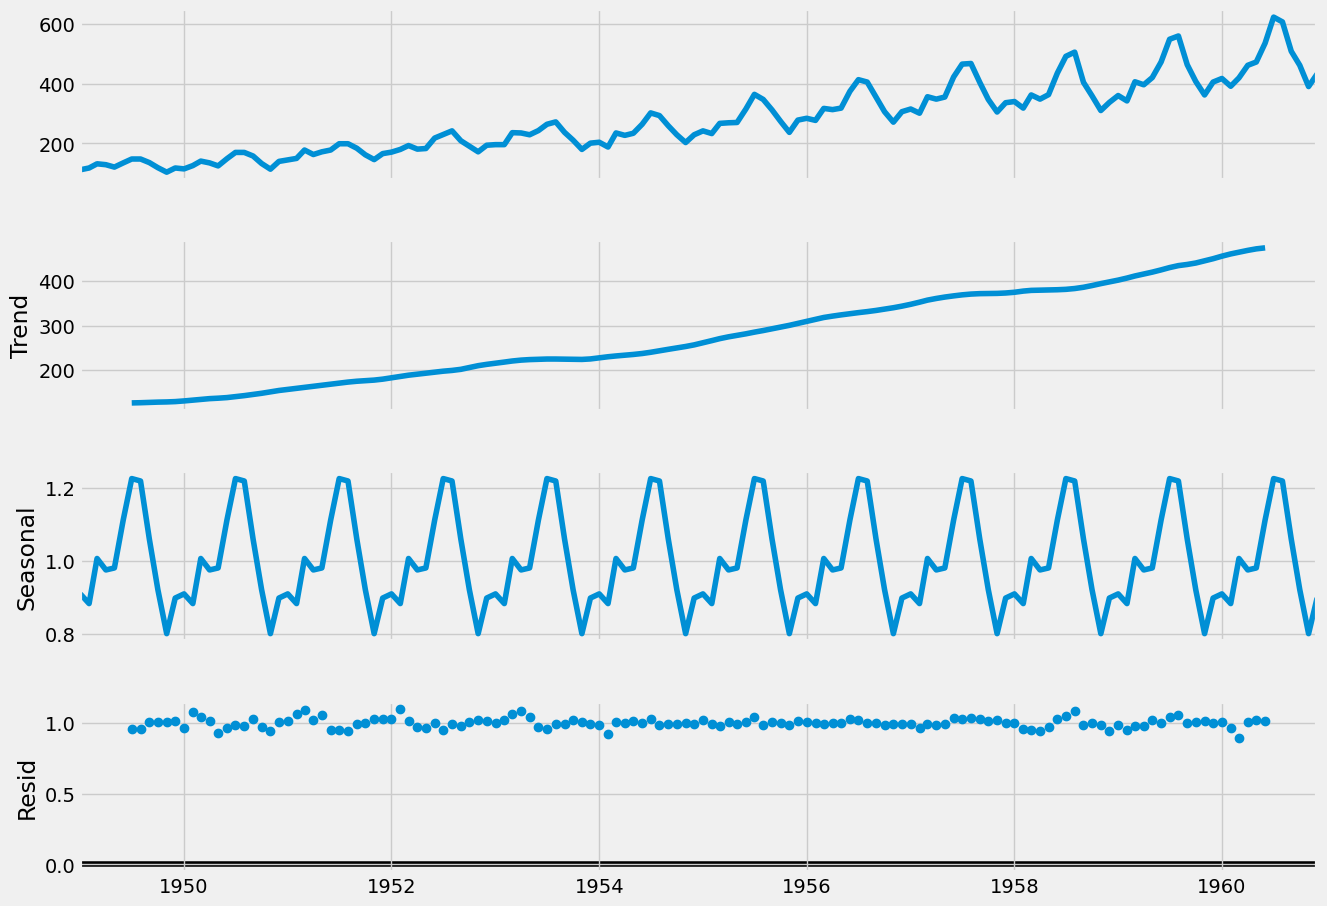

In [54]:
result = seasonal_decompose(sales2,model='multiplicative')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15,10)

# Stationarity test - ADF

In [50]:
def statianary_test(data):
  result = adfuller(data)
  print('ADF Statistic: {}'.format(result[0]))
  print('p-value: {}'.format(result[1]))
  print('lags-used: {}'.format(result[2]))
  print('Number of Observations: {}'.format(result[3]))
  print('Critical Values:')
  for key,value in result[4].items():
    print('\t{} : {}'.format(key,value))
statianary_test(data['Passengers'])

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641
lags-used: 13
Number of Observations: 130
Critical Values:
	1% : -3.4816817173418295
	5% : -2.8840418343195267
	10% : -2.578770059171598


The p-value is quite high (close to 1), which means there is weak evidence to reject the null hypothesis of non-stationarity. Essentially, this suggests that the time series is non-stationary.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

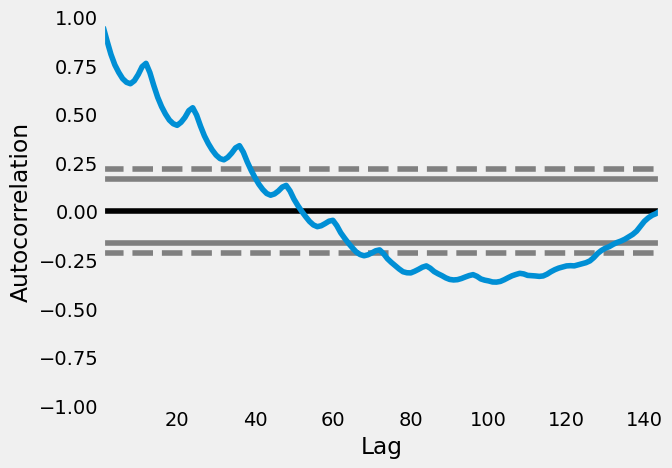

In [55]:
pd.plotting.autocorrelation_plot(data['Passengers'])

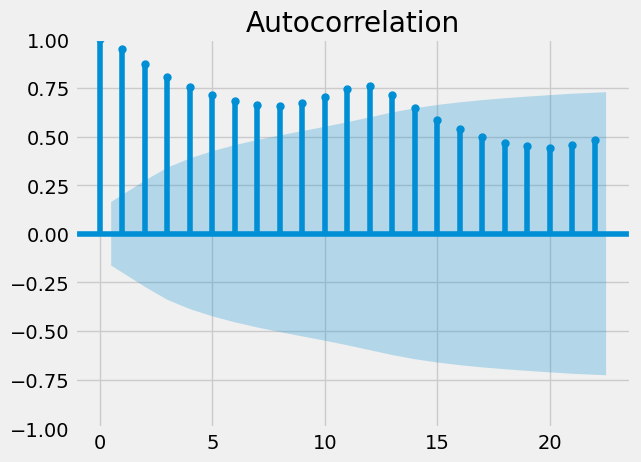

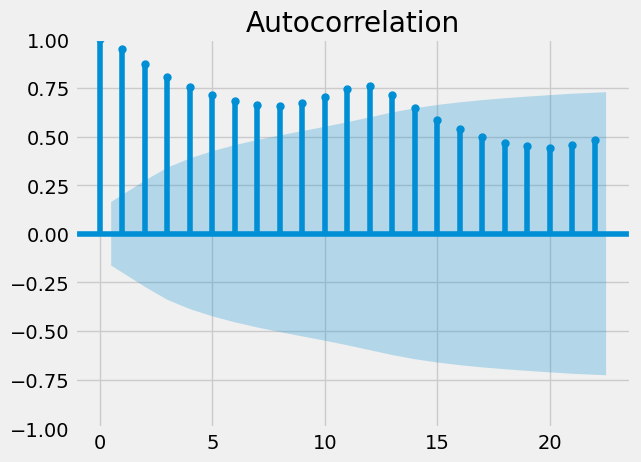

In [59]:
plot_acf(data['Passengers'])

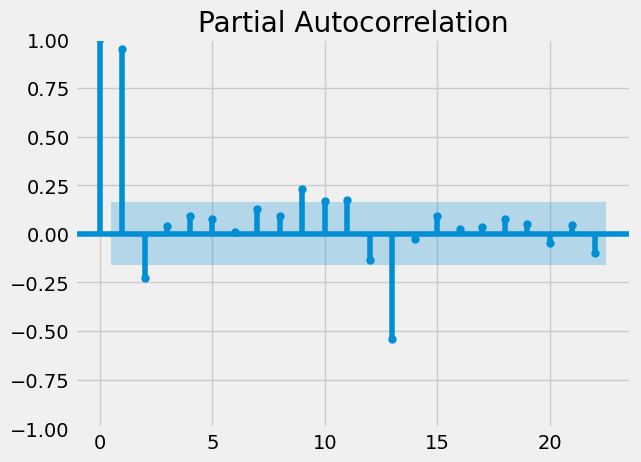

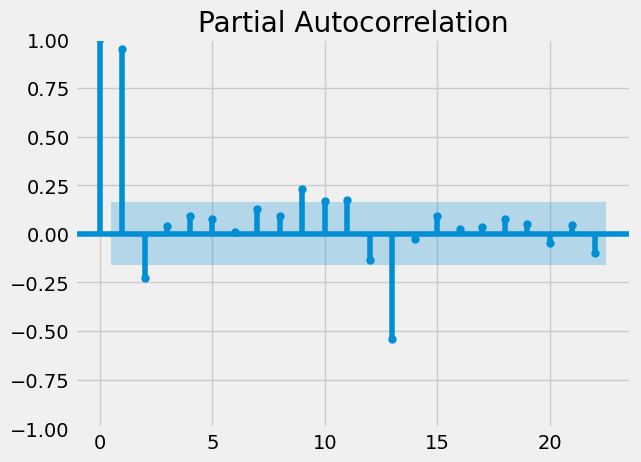

In [60]:
plot_pacf(data['Passengers'])

#SARIMAX MODEL

In [77]:
# Train-test split (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data, test_data = data['Passengers'][:train_size], data['Passengers'][train_size:]

In [78]:
p,d,q =5,1,1
model = sm.tsa.statespace.SARIMAX(train_data,
                                  order=(p,d,q),
                                  seasonal_order=(p,d,q,12)
                                  )
model = model.fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  115
Model:             SARIMAX(5, 1, 1)x(5, 1, 1, 12)   Log Likelihood                -368.070
Date:                            Sun, 15 Sep 2024   AIC                            762.140
Time:                                    05:22:34   BIC                            796.264
Sample:                                         0   HQIC                           775.958
                                            - 115                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0227      5.613     -0.004      0.997     -11.025      10.979
ar.L2          0.0755      1.271   

In [94]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Forecast the length of test_data and an additional period (e.g., 12 month)
forecast_periods = len(test_data) + 12
forecast = model.get_forecast(steps=forecast_periods).predicted_mean

# Split forecast into forecast for the test data and forecast for the next period
forecast_test_data = forecast[:len(test_data)]
forecast_next_month = forecast[len(test_data):]

# Calculate error metrics for the test data forecast
mae = mean_absolute_error(test_data, forecast_test_data)
rmse = np.sqrt(mean_squared_error(test_data, forecast_test_data))
mape = np.mean(np.abs((test_data - forecast_test_data) / test_data)) * 100


# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Absolute Error (MAE): 22.611735226827378
Root Mean Squared Error (RMSE): 27.287775375188374
Mean Absolute Percentage Error (MAPE): 4.908898870151222%


<Axes: >

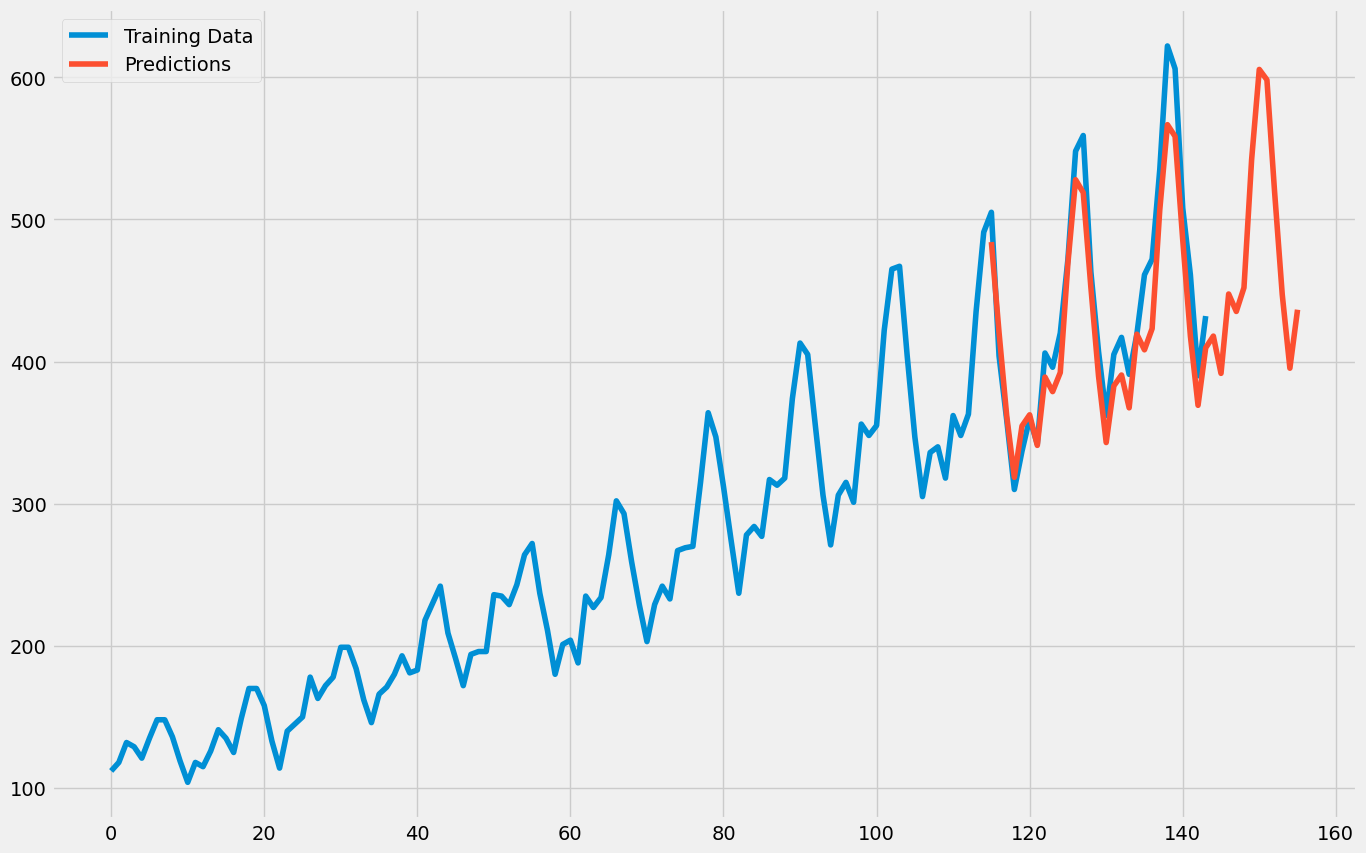

In [95]:
data['Passengers'].plot(legend=True,label='Training Data',figsize=(15,10))
forecast.plot(legend=True,label='Predictions')